In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Workers(object):
    def __init__(self, count_idle):
        self.count_idle = count_idle

In [3]:
class Queue(object):
    def __init__(self, q_length):
        self.length = q_length

In [4]:
class State(object):
    def __init__(self, time, workers, regular_queue, priority_queue):
        self.time = time
        self.reg_q_length = regular_queue.length
        self.pri_q_length = priority_queue.length
        self.idle_workers = workers.count_idle

In [5]:
def schedule_new_package(time, _lambda, events):
    new_package_arrival_time = time + np.random.exponential(1/_lambda)
    heapq.heappush(events, (new_package_arrival_time, "NewPackage"))

In [6]:
def schedule_packing(time, _lambda, events):
    packed_time = time + np.random.exponential(1/_lambda)
    heapq.heappush(events, (packed_time, "PackagePacked"))

In [7]:
# Simulation function with default parameter values specified in the project assignment
def simulate(new_package_arrival_rate=4, regular_package_prob=0.9, packing_rate=0.5, num_workers=9, T=2000):
    # initialize variables
    events = []
    states = []
    regular_queue = Queue(q_length=0) # no package in regular queue
    priority_queue = Queue(q_length=0) # no package in priority queue
    workers = Workers(count_idle=num_workers) # all workers are idle

    t = 0
    schedule_new_package(t, new_package_arrival_rate, events) # schedule the first new package
    states.append(State(t, workers, regular_queue, priority_queue)) # record simulation state

    while t <= T:
        t, event_type = heapq.heappop(events)
        if event_type == "PackagePacked": # if a worker finishes packing
            if priority_queue.length > 0: # pack the next package in priority queue
                schedule_packing(t, packing_rate, events) # schedule packaging to be finished
                priority_queue.length -= 1
            elif regular_queue.length > 0: # pack the next package in regular queue
                schedule_packing(t, packing_rate, events) # schedule packaging to be finished
                regular_queue.length -= 1
            else:
                workers.count_idle += 1 # this worker becomes idle
        elif event_type == "NewPackage": # if a new package arrives
            schedule_new_package(t, new_package_arrival_rate, events) # schedule the next new package
            if workers.count_idle > 0: # assign the new package to an idle worker
                schedule_packing(t, packing_rate, events) # schedule packaging to be finished
                workers.count_idle -= 1 # this worker becomes busy
            elif np.random.rand() < regular_package_prob: # new package is regular with probability
                regular_queue.length += 1 # put the new pacakge in regular queue
            else:
                priority_queue.length += 1 # put the new pacakge in priority queue
        states.append(State(t, workers, regular_queue, priority_queue)) # record simulation state
        
    return states

In [8]:
np.random.seed(1)
states = simulate()

timestamps = [s.time for s in states]

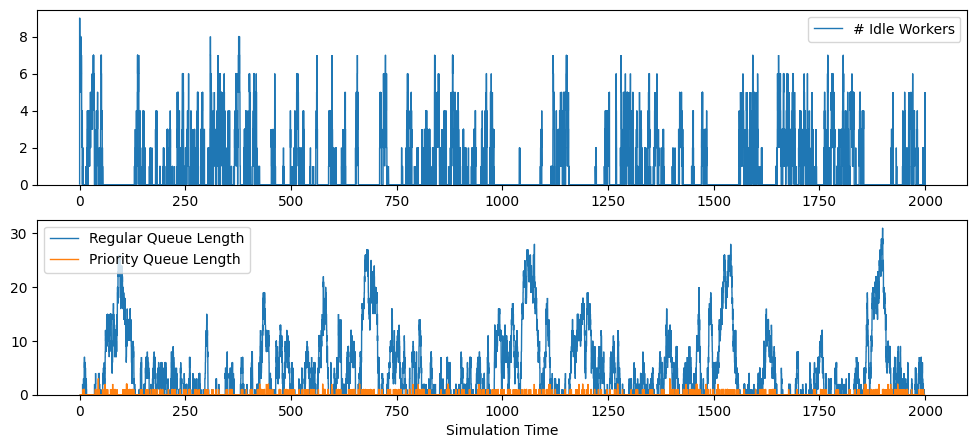

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.stairs(values=[s.idle_workers for s in states[:-1]], edges=timestamps, label="# Idle Workers")
plt.legend()
plt.subplot(2,1,2)
plt.stairs(values=[s.reg_q_length for s in states[:-1]], edges=timestamps, label="Regular Queue Length")
plt.stairs(values=[s.pri_q_length for s in states[:-1]], edges=timestamps, label="Priority Queue Length")
plt.legend()
plt.xlabel("Simulation Time")
plt.show()

##### show only the first 100 unit time

In [10]:
truncate_idx = min(range(len(timestamps)), key=lambda i: abs(timestamps[i] - 100))
states_first100 = states[:truncate_idx]
timestamps_first100 = [s.time for s in states_first100]

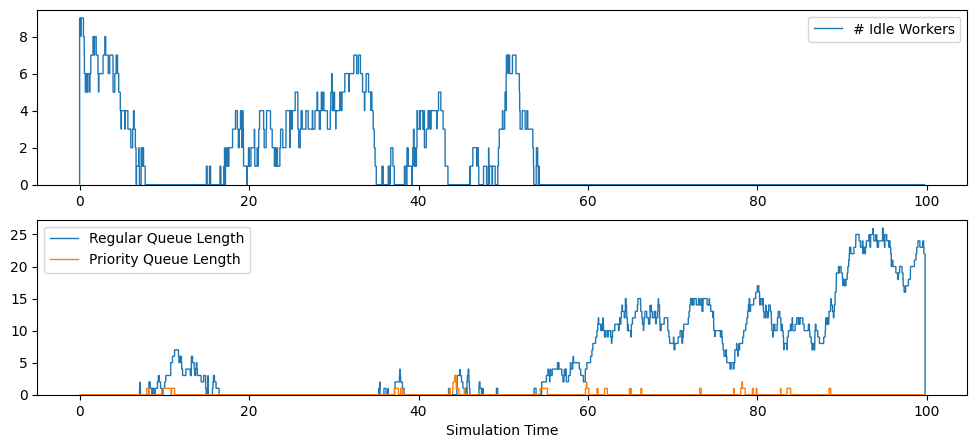

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.stairs(values=[s.idle_workers for s in states_first100[:-1]], edges=timestamps_first100, label="# Idle Workers")
plt.legend()
plt.subplot(2,1,2)
plt.stairs(values=[s.reg_q_length for s in states_first100[:-1]], edges=timestamps_first100, label="Regular Queue Length")
plt.stairs(values=[s.pri_q_length for s in states_first100[:-1]], edges=timestamps_first100, label="Priority Queue Length")
plt.legend()
plt.xlabel("Simulation Time")
plt.show()

##### discard the first 20 unit time as the burn-in period

In [12]:
burnin_idx = min(range(len(timestamps)), key=lambda i: abs(timestamps[i] - 20))
states_discard_burnin = states[burnin_idx:]
timestamps_discard_burnin = [s.time for s in states_discard_burnin]

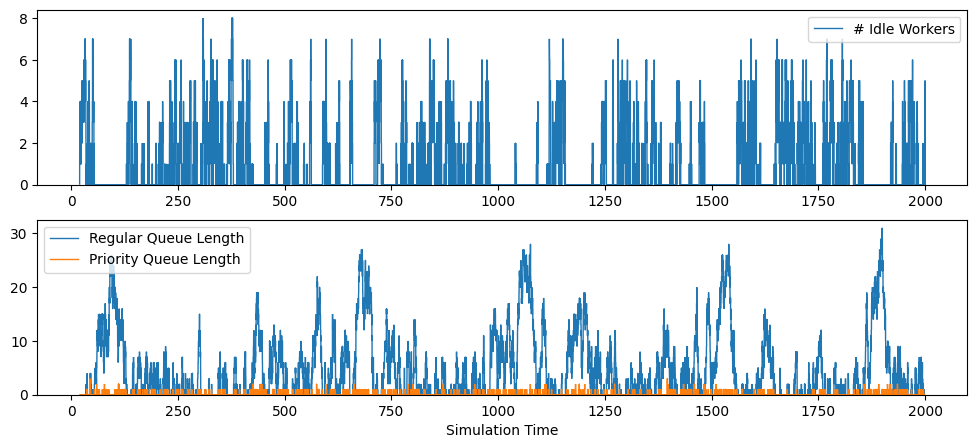

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.stairs(values=[s.idle_workers for s in states_discard_burnin[:-1]], edges=timestamps_discard_burnin, label="# Idle Workers")
plt.legend()
plt.subplot(2,1,2)
plt.stairs(values=[s.reg_q_length for s in states_discard_burnin[:-1]], edges=timestamps_discard_burnin, label="Regular Queue Length")
plt.stairs(values=[s.pri_q_length for s in states_discard_burnin[:-1]], edges=timestamps_discard_burnin, label="Priority Queue Length")
plt.legend()
plt.xlabel("Simulation Time")
plt.show()

In [14]:
def calculate_CI_batch(num_batches, values, weights=[]):
    batch_size = int(np.floor(len(values)/num_batches))
    batch_means = np.zeros(num_batches)
    for i in range(num_batches):
        batch_values = values[i*batch_size:(i+1)*batch_size]
        if len(weights) == 0:
            batch_means[i] = np.mean(batch_values)
        else:
            batch_weights = weights[i*batch_size:(i+1)*batch_size]
            batch_means[i] = np.average(batch_values, weights = batch_weights)
    mean = np.mean(batch_means)
    se = np.std(batch_means) / np.sqrt(num_batches)
    CI_lower = mean - 1.96*se
    CI_upper = mean + 1.96*se
    return mean, se, CI_lower, CI_upper

In [15]:
time_intervals_discard_burnin = np.diff(timestamps_discard_burnin)
num_batches = 50

reg_q_length = [int(s.reg_q_length) for s in states_discard_burnin[:-1]]
print("Average regular queue length:")
print("Mean = {:.3f}, Standard Error = {:.3f}, 95% CI = [{:.3f}, {:.3f}]".format(*calculate_CI_batch(num_batches,
                                                                                                     reg_q_length,
                                                                                                     time_intervals_discard_burnin)))

pri_q_length = [int(s.pri_q_length) for s in states_discard_burnin[:-1]]
print("Average priority queue length:")
print("Mean = {:.3f}, Standard Error = {:.3f}, 95% CI = [{:.3f}, {:.3f}]".format(*calculate_CI_batch(num_batches,
                                                                                                     pri_q_length,
                                                                                                     time_intervals_discard_burnin)))

idle_workers = [int(s.idle_workers) for s in states_discard_burnin[:-1]]
print("Average number of idle workers:")
print("Mean = {:.3f}, Standard Error = {:.3f}, 95% CI = [{:.3f}, {:.3f}]".format(*calculate_CI_batch(num_batches,
                                                                                                     idle_workers,
                                                                                                     time_intervals_discard_burnin)))

fully_utilized = [int(s.idle_workers==0) for s in states_discard_burnin[:-1]]
print("Proportion in time when workers are fully utilized:")
print("Mean = {:.4f}, Standard Error = {:.4f}, 95% CI = [{:.4f}, {:.4f}]".format(*calculate_CI_batch(num_batches,
                                                                                                     fully_utilized,
                                                                                                     time_intervals_discard_burnin)))

Average regular queue length:
Mean = 4.816, Standard Error = 0.647, 95% CI = [3.547, 6.085]
Average priority queue length:
Mean = 0.064, Standard Error = 0.005, 95% CI = [0.054, 0.075]
Average number of idle workers:
Mean = 0.862, Standard Error = 0.090, 95% CI = [0.685, 1.039]
Proportion in time when workers are fully utilized:
Mean = 0.6851, Standard Error = 0.0294, 95% CI = [0.6274, 0.7427]


##### what if we hire fewer workers?

In [16]:
np.random.seed(1)
states = simulate(num_workers=8)

timestamps = [s.time for s in states]

In [17]:
time_intervals = np.diff(timestamps)
fully_utilized = [int(s.idle_workers==0) for s in states[:-1]]
print("Proportion in time when workers are fully utilized:")
print("Mean = {:.4f}, Standard Error = {:.4f}, 95% CI = [{:.4f}, {:.4f}]".format(*calculate_CI_batch(num_batches,
                                                                                                     fully_utilized,
                                                                                                     time_intervals)))

Proportion in time when workers are fully utilized:
Mean = 0.9866, Standard Error = 0.0068, 95% CI = [0.9732, 1.0000]


We would achieve a full utilization proportion of over 98%, however, at a cost of overloading regular queue length > 120.

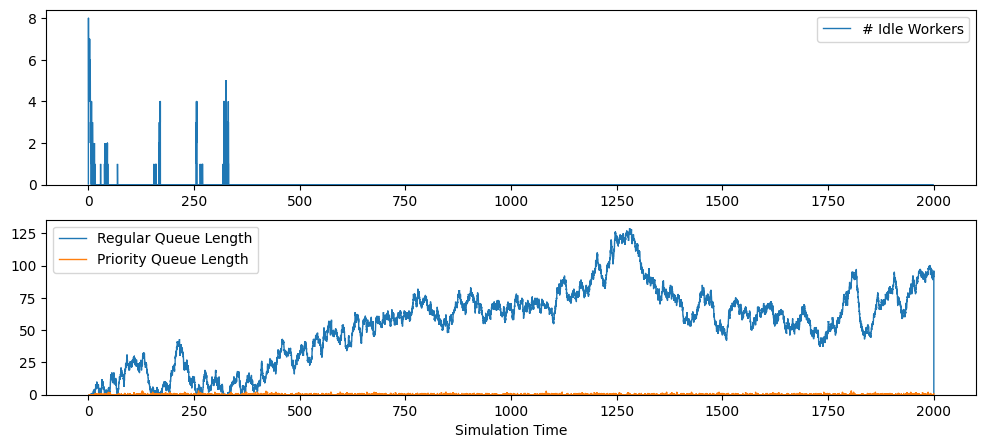

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.stairs(values=[s.idle_workers for s in states[:-1]], edges=timestamps, label="# Idle Workers")
plt.legend()
plt.subplot(2,1,2)
plt.stairs(values=[s.reg_q_length for s in states[:-1]], edges=timestamps, label="Regular Queue Length")
plt.stairs(values=[s.pri_q_length for s in states[:-1]], edges=timestamps, label="Priority Queue Length")
plt.legend()
plt.xlabel("Simulation Time")
plt.show()